In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/segmentation-data/labels_names_220425.npy
/kaggle/input/segmentation-data/videos_1.npy
/kaggle/input/segmentation-data/videos.npy
/kaggle/input/segmentation-data/masks_1.npy
/kaggle/input/segmentation-data/videos_check_220425.npy
/kaggle/input/segmentation-data/labels_220425.npy
/kaggle/input/segmentation-data/masks.npy
/kaggle/input/segmentation-data/masks_check_220425.npy
/kaggle/input/segmentation-data/yolo_seg_small_040325.pt


In [2]:
import torch

# Проверка доступности CUDA
if torch.cuda.is_available():
    print("CUDA доступна")
    print("Имя устройства:", torch.cuda.get_device_name(0))
    print("Кол-во устройств:", torch.cuda.device_count())

CUDA доступна
Имя устройства: Tesla T4
Кол-во устройств: 2


In [3]:
# Подключаем датасет
project_dir = '/kaggle/input/segmentation-data/'
videos_file = os.path.join(project_dir, 'videos_1.npy')
masks_file = os.path.join(project_dir, 'masks_1.npy')

try:
    videos = np.load(videos_file)
    print("Файл 'videos' загружен успешно.")
except FileNotFoundError:
    print("Файл 'videos' не найден. Проверьте правильность пути.")

Файл 'videos' загружен успешно.


In [4]:
# Загрузка массивов
videos = np.load(videos_file)
masks = np.load(masks_file)

print(f"Размерность массива видео: {videos.shape}")     # (Число видео, Число кадров, Высота, Ширина)
print(f"Размерность массива меток: {masks.shape}")      # (Размерности должны совпадать)

if videos.shape == masks.shape:
    print("Размерности 'videos' и 'masks' совпадают")
else:
    print("Размерности 'videos' и 'masks' не совпадают")

print(type(videos))

Размерность массива видео: (412, 54, 224, 224)
Размерность массива меток: (412, 54, 224, 224)
Размерности 'videos' и 'masks' совпадают
<class 'numpy.ndarray'>


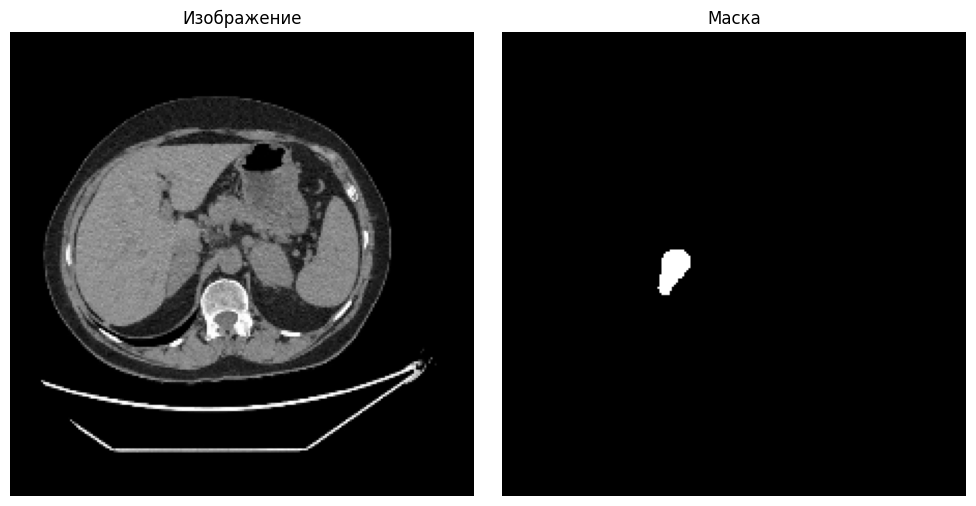

In [5]:
# проверим пару кадров в videos и masks на совпадение
# так как маски выделяют только образования, то проверяем то место, где есть сама маска - белая часть

# маска состоит из различных пикселей, поэтому что в цветовом канале меньше 127 - 0, больше - 25
masks = np.where(masks < 127, 0, 255)

# отрисуем 1 кадр с образованием и его маской
kadr = 25
img = videos[0,kadr]
img_seg = masks[0,kadr]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Изображение") 
axes[0].axis('off')

axes[1].imshow(img_seg, cmap='gray', vmin=0, vmax=255)
axes[1].set_title("Маска") 
axes[1].axis('off') 

plt.tight_layout()
plt.show()

In [6]:
# Ищу и удаляю дубликаты

dublicates = []

for i in range(len(masks)):
    for j in range(i + 1, len(videos)):  # исключаем сравнение элемента с самим собой
        if np.array_equal(videos[i], videos[j]):
            dublicates.append(j)

dublicates = np.array(dublicates)

keep_indices = np.setdiff1d(np.arange(videos.shape[0]), dublicates)

# Оставляем только нужные видео
videos = videos[keep_indices]
masks = masks[keep_indices]

print(f"Осталось {videos.shape[0]} видео после удаления дубликатов")

Осталось 400 видео после удаления дубликатов


In [7]:
# Теперь будем подготавливать данные. Для этого сохраним "num_to_save" видео отдельно, а оставшихся видео

num_to_save = 15

selected_indices = np.random.choice(videos.shape[0], num_to_save, replace=False)
remaining_indices = np.setdiff1d(np.arange(videos.shape[0]), selected_indices)

videos_saved = videos[selected_indices]
masks_saved = masks[selected_indices]

images_saved = videos_saved.reshape(-1, 224, 224)
masks_saved_images = masks_saved.reshape(-1, 224, 224)

videos = videos[remaining_indices]
masks = masks[remaining_indices]

print('размеры массивов до превращения видео в набор картинок')
print(videos.shape)
print(masks.shape)
print("Размер массивов с test картинками и масками")
print(images_saved.shape)
print(masks_saved_images.shape)

размеры массивов до превращения видео в набор картинок
(385, 54, 224, 224)
(385, 54, 224, 224)
Размер массивов с test картинками и масками
(810, 224, 224)
(810, 224, 224)


In [8]:
# Делаю из видео массив картинок и перемешиваю их

videos = videos.reshape(-1, 224, 224)  # (n * m, 224, 224)
masks = masks.reshape(-1, 224, 224)    # (n * m, 224, 224)

indices = np.arange(videos.shape[0])
np.random.shuffle(indices)

videos = videos[indices]
masks = masks[indices]

print(videos.shape)
print(masks.shape)

(20790, 224, 224)
(20790, 224, 224)


In [9]:
# теперь надо посмотреть сколько картинок отражают наличие образования, а сколько нет, и количество
# картинок, которые не отражают наличие образования сократить, чтобы картинок с и без образования
# было примерно одинаково

masks_w = [] 
masks_b = []

# Проходим по всем картинкам
for idx in range(masks.shape[0]):
    if np.any(masks[idx] != 0):
        masks_w.append(idx)
    else:
        masks_b.append(idx)

print('Количество картинок, на которых видно образование',len(masks_w))
print('Количество картинок, на которых не видно образования',len(masks_b))
print('Индексы картинок с образованием', masks_w[:10],'...')

Количество картинок, на которых видно образование 4120
Количество картинок, на которых не видно образования 16670
Индексы картинок с образованием [0, 1, 2, 3, 10, 14, 19, 23, 26, 35] ...


In [10]:
# теперь из всех индексов картинок без образования оставим только первые n = len(masks_w) картинок,
# и сохраним нужные картинки

masks_b = masks_b[:len(masks_w)]

idices = masks_w
idices = np.concatenate((masks_w, masks_b))
np.random.shuffle(idices)

videos = videos[idices]
masks_tumor = masks[idices]

print(videos.shape)
print(masks_tumor.shape)

(8240, 224, 224)
(8240, 224, 224)


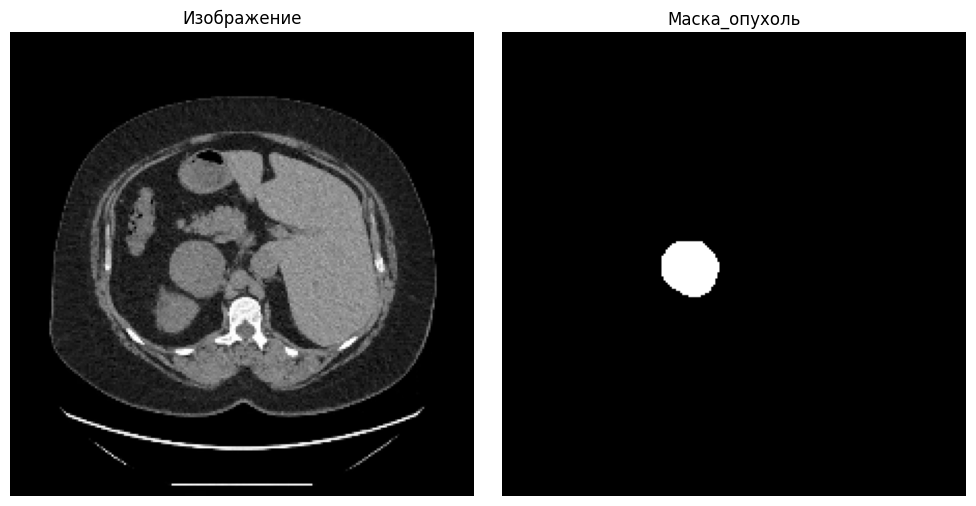

In [11]:
# Проверим, что соответствие между видео и маской созранилось

kadr = 5
img = videos[kadr]
img_seg = masks_tumor[kadr]
# img_seg_1 = masks_not_tumor[kadr]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Изображение") 
axes[0].axis('off')

axes[1].imshow(img_seg, cmap='gray', vmin=0, vmax=255)
axes[1].set_title("Маска_опухоль") 
axes[1].axis('off')

# axes[2].imshow(img_seg_1, cmap='gray', vmin=0, vmax=255)
# axes[2].set_title("Маска_фон") 
# axes[2].axis('off')

plt.tight_layout()
plt.show()

In [12]:
import shutil
import os

working_dir = '/kaggle/working'

# Удаляем все файлы и папки внутри /kaggle/working
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    if os.path.isdir(item_path):
        shutil.rmtree(item_path)
    else:
        os.remove(item_path)

print(f"Все содержимое папки {working_dir} удалено")

Все содержимое папки /kaggle/working удалено


In [13]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import yaml

In [14]:
X_train, X_val, y_train, y_val = train_test_split(videos, masks_tumor, test_size=0.1, random_state=42)

# Общая функция подготовки данных
def prepare_split(X, y, split):
    img_dir = os.path.join('data', split, 'images')
    lbl_dir = os.path.join('data', split, 'labels')
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(lbl_dir, exist_ok=True)

    for i, (img, mask) in enumerate(zip(X, y)):
        fn = f"{i:04d}.png"
        # 1) Сохраняем изображение в BGR
        gray = img.astype('uint8')
        bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        cv2.imwrite(os.path.join(img_dir, fn), bgr)

        # 2) Находим контуры объектов на маске
        m = (mask > 0).astype('uint8') * 255
        contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 3) Пишем .txt с полигональными метками (YOLO instance segmentation)
        txt_path = os.path.join(lbl_dir, fn.replace('.png', '.txt'))
        lines = []
        h, w = m.shape
        for cnt in contours:
            # нужно минимум 3 точек
            if len(cnt) < 3: continue
            # нормализуем координаты
            poly = cnt.flatten().tolist()
            norm = []
            for idx, coord in enumerate(poly):
                if idx % 2 == 0:  # x
                    norm.append(coord / w)
                else:            # y
                    norm.append(coord / h)
            # YOLOv8 expects: class-index + coords
            lines.append('0 ' + ' '.join(f"{v:.6f}" for v in norm))
        # Сохраняем, даже если нет контуров (пустой файл)
        with open(txt_path, 'w') as f:
            f.write('\n'.join(lines))

# Подготовка split’ов
prepare_split(X_train, y_train, 'train')
prepare_split(X_val, y_val, 'val')

# Генерация data.yaml
yaml_config = {
    'path': 'data',
    'train': 'train/images',
    'val': 'val/images',
    'names': {0: 'tumor'}
}
with open('data/data.yaml', 'w') as f:
    yaml.dump(yaml_config, f)

print("Данные SNP-полигональных меток созданы для train/val, файл data/data.yaml сохранён.")

Данные SNP-полигональных меток созданы для train/val, файл data/data.yaml сохранён.


# Данные для обучения по фото готовы, можно переходить к модели

# Теперь перейдем к работе с моделью YOLO

In [15]:
!python -m pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.2 MB/s eta 0:00:0000:01


In [16]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [17]:
# model_nano = YOLO("yolo11n-seg.pt")
model_small = YOLO("yolo11s-seg.pt")
# model_medium = YOLO("yolo11m-seg.pt")
# model_large = YOLO("yolo11l-seg.pt")
# model_extra = YOLO("yolo11x-seg.pt")

100%|██████████| 19.7M/19.7M [00:00<00:00, 151MB/s]


In [18]:
model = model_small

In [19]:
results = model.train(
    task='segment',
    data="/kaggle/working/data/data.yaml",
    epochs=250,
    imgsz=224,
    project='/kaggle/working/results',
    batch=64,
    dropout=0.5,
)

Ultralytics 8.3.139 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.5, dynamic=False, embed=None, epochs=250, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pre

100%|██████████| 755k/755k [00:00<00:00, 17.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.2MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1335.8±388.3 MB/s, size: 40.8 KB)


train: Scanning /kaggle/working/data/train/labels... 7416 images, 3721 backgrounds, 0 corrupt: 100%|██████████| 7416/7416 [00:07<00:00, 1018.46it/s]


train: New cache created: /kaggle/working/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 834.8±314.6 MB/s, size: 51.6 KB)


val: Scanning /kaggle/working/data/val/labels... 824 images, 405 backgrounds, 0 corrupt: 100%|██████████| 824/824 [00:00<00:00, 927.58it/s]

val: New cache created: /kaggle/working/data/val/labels.cache


Plotting labels to /kaggle/working/results/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /kaggle/working/results/train
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/250      2.41G      1.888      2.448      4.538      1.252         49        224: 100%|██████████| 116/116 [00:37<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        824        423      0.718       0.53      0.584      0.341      0.693      0.504      0.559      0.281



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/250      3.11G      1.394      1.603      1.363      0.957         40        224: 100%|██████████| 116/116 [00:32<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]

                   all        824        423      0.596      0.447       0.49      0.286      0.587       0.44      0.473      0.231



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/250      3.11G      1.639      1.774        1.5      1.029         37        224: 100%|██████████| 116/116 [00:32<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        824        423      0.333      0.504      0.393      0.191       0.33      0.507      0.393      0.204



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/250      3.12G      1.689      1.824      1.516      1.087         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]

                   all        824        423      0.548      0.412      0.426      0.226      0.606      0.385      0.423      0.197



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/250      3.12G      1.613      1.718      1.339      1.054         47        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]

                   all        824        423      0.673      0.532      0.558      0.288       0.69      0.474       0.53      0.236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/250      3.12G      1.501      1.579      1.203      1.025         33        224: 100%|██████████| 116/116 [00:34<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]

                   all        824        423      0.743       0.61      0.645      0.358      0.728      0.598      0.623      0.308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/250      3.12G      1.434      1.509      1.123       1.01         36        224: 100%|██████████| 116/116 [00:34<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]

                   all        824        423      0.734      0.582      0.639      0.364       0.72       0.53      0.581      0.281



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/250      3.12G      1.393      1.521      1.076     0.9884         45        224: 100%|██████████| 116/116 [00:34<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        824        423      0.711      0.588      0.609       0.38      0.702      0.582      0.599      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/250      3.12G      1.348      1.458      1.011     0.9801         43        224: 100%|██████████| 116/116 [00:34<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]

                   all        824        423      0.785      0.621      0.676      0.408      0.785      0.621      0.681      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/250      3.12G      1.322      1.436     0.9844     0.9882         35        224: 100%|██████████| 116/116 [00:34<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]

                   all        824        423      0.799      0.602      0.693      0.425      0.816      0.566      0.653      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/250      3.12G      1.298      1.402     0.9725     0.9679         33        224: 100%|██████████| 116/116 [00:34<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]

                   all        824        423       0.81      0.648      0.727      0.443       0.79      0.614      0.704      0.344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/250      3.12G      1.285        1.4     0.9365     0.9658         39        224: 100%|██████████| 116/116 [00:34<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        824        423      0.725      0.492      0.604      0.401       0.79      0.473      0.585      0.324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/250      3.12G      1.274      1.395     0.9165     0.9601         38        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]

                   all        824        423      0.793      0.622      0.684      0.437       0.77      0.598      0.656      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/250      3.12G      1.237      1.329     0.8867     0.9507         34        224: 100%|██████████| 116/116 [00:33<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        824        423      0.825      0.622      0.708      0.463      0.815      0.608      0.669       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/250      3.12G      1.224      1.301     0.8418     0.9442         33        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

                   all        824        423      0.872      0.669      0.777      0.494      0.837      0.638      0.737       0.39



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/250      3.12G      1.231       1.32     0.8655     0.9408         42        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]

                   all        824        423      0.857      0.702      0.761      0.495      0.836      0.686      0.731      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/250      3.12G       1.19      1.251     0.8213     0.9383         29        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]

                   all        824        423      0.895      0.683      0.784      0.505      0.886      0.674      0.766      0.408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/250      3.12G      1.176      1.254     0.8214      0.934         31        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]

                   all        824        423      0.851       0.66       0.73      0.488      0.835      0.641      0.688      0.378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/250      3.12G      1.181      1.255     0.8124     0.9378         38        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]

                   all        824        423      0.863      0.704      0.781      0.507      0.844      0.678       0.74      0.386



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/250      3.12G      1.175      1.263     0.8027     0.9387         36        224: 100%|██████████| 116/116 [00:33<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]

                   all        824        423      0.881      0.714      0.767      0.504      0.843      0.672      0.708      0.375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/250      3.12G      1.149      1.264      0.765     0.9249         44        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]

                   all        824        423      0.882      0.676      0.754      0.519      0.852       0.66      0.743      0.412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/250      3.12G      1.139      1.223     0.7714     0.9206         48        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]

                   all        824        423      0.898      0.684      0.769      0.503       0.87      0.663      0.735       0.39



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/250      3.12G      1.135      1.246     0.7521     0.9197         34        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]

                   all        824        423      0.902      0.714      0.771      0.491      0.856      0.676      0.709      0.375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/250      3.12G      1.121      1.203     0.7377     0.9188         38        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]

                   all        824        423      0.843      0.711      0.763      0.515      0.867      0.662      0.749      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/250      3.12G      1.141      1.252     0.7553       0.92         31        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

                   all        824        423      0.853       0.73      0.789      0.516      0.805      0.693      0.749      0.412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/250      3.12G      1.112      1.186     0.7297     0.9201         34        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]

                   all        824        423      0.837      0.729      0.761      0.487      0.879      0.671      0.728      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/250      3.12G      1.122       1.18     0.7347     0.9152         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]

                   all        824        423      0.879      0.723      0.789      0.531      0.822      0.674      0.739      0.408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/250      3.12G      1.115      1.211     0.7274     0.9133         33        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

                   all        824        423      0.906      0.732       0.81      0.553      0.877      0.708      0.788      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/250      3.12G      1.095      1.212     0.7082      0.919         39        224: 100%|██████████| 116/116 [00:34<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]

                   all        824        423      0.911      0.747       0.81      0.539      0.872      0.721      0.773      0.404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/250      3.12G      1.097       1.16     0.7187     0.9062         48        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.87it/s]

                   all        824        423      0.914       0.73      0.817      0.546       0.89       0.71      0.785      0.402



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/250      3.12G      1.081      1.157     0.6783     0.9099         35        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]

                   all        824        423      0.924      0.728      0.813      0.532      0.871      0.693      0.768       0.39



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/250      3.12G      1.091      1.168     0.6923     0.9098         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]

                   all        824        423      0.897      0.738      0.803      0.534      0.883      0.716      0.777      0.408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/250      3.12G      1.053       1.13      0.674     0.9031         48        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]

                   all        824        423      0.847      0.738        0.8      0.551      0.854      0.695      0.781      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/250      3.12G      1.054      1.138     0.6645      0.905         37        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]

                   all        824        423      0.904      0.711      0.804      0.548      0.878      0.695      0.773      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/250      3.12G      1.047      1.172     0.6706     0.8974         42        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]

                   all        824        423      0.853      0.778      0.818       0.55      0.892      0.706      0.784      0.419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/250      3.12G      1.054      1.164      0.661     0.9012         35        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

                   all        824        423      0.881      0.759      0.827      0.565      0.898      0.706      0.797      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/250      3.12G      1.067      1.167     0.6708     0.9074         36        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]

                   all        824        423      0.884      0.775      0.829      0.571      0.863      0.721      0.778      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/250      3.12G      1.061      1.141     0.6529     0.9019         38        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]

                   all        824        423       0.89       0.74      0.815      0.564       0.91      0.681      0.766      0.403



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/250      3.12G       1.02      1.129      0.635     0.8947         37        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

                   all        824        423      0.895      0.744      0.823      0.562      0.899        0.7      0.769      0.399



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/250      3.12G      1.043      1.127     0.6466     0.8963         38        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

                   all        824        423      0.922      0.723      0.829      0.579      0.909      0.702      0.802      0.445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/250      3.12G      1.044      1.114     0.6411     0.9025         52        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]

                   all        824        423      0.883      0.787      0.839      0.578      0.924       0.72      0.806       0.44



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/250      3.12G      1.036       1.12     0.6446     0.8948         44        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]

                   all        824        423      0.896      0.735      0.839      0.572      0.876      0.686      0.778      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/250      3.12G      1.047      1.137     0.6467     0.8964         39        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]

                   all        824        423      0.927      0.747      0.839      0.573      0.901      0.716      0.786      0.429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/250      3.12G       1.04      1.117     0.6272     0.8987         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

                   all        824        423      0.909      0.778      0.847      0.586      0.907      0.712      0.806      0.427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/250      3.12G      1.015        1.1     0.6346     0.8939         41        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]

                   all        824        423      0.891      0.769      0.841      0.582      0.875      0.719      0.797      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/250      3.12G       1.04      1.113     0.6362     0.8959         52        224: 100%|██████████| 116/116 [00:33<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]

                   all        824        423      0.892      0.777      0.841      0.583       0.92      0.702      0.797      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/250      3.12G      1.023       1.09     0.6237     0.8989         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]

                   all        824        423      0.891      0.771      0.842      0.581      0.893      0.723      0.811      0.446



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/250      3.12G      1.015      1.085     0.6182     0.8899         39        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]

                   all        824        423      0.905      0.778       0.85      0.588      0.893      0.733      0.819      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/250      3.12G      1.014        1.1     0.6186     0.8912         45        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]

                   all        824        423       0.91      0.789      0.846       0.58      0.924      0.716       0.79      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/250      3.12G      1.008      1.073     0.5965     0.8873         39        224: 100%|██████████| 116/116 [00:33<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]

                   all        824        423      0.913      0.796      0.854      0.597      0.932      0.733       0.82      0.449



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/250      3.12G     0.9862      1.082     0.6092     0.8845         32        224: 100%|██████████| 116/116 [00:33<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]

                   all        824        423      0.926      0.764      0.854      0.601      0.905      0.716       0.81      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/250      3.12G     0.9979      1.093     0.6011     0.8887         37        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]

                   all        824        423      0.893      0.787      0.851      0.598       0.88      0.745      0.827       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/250      3.12G      0.988      1.063      0.593      0.888         48        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]

                   all        824        423      0.903       0.77      0.841        0.6      0.889      0.755      0.833      0.457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/250      3.12G      1.001      1.077     0.5932     0.8918         37        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]

                   all        824        423      0.919      0.778      0.856       0.59      0.891      0.752      0.833      0.456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/250      3.12G     0.9938      1.053     0.5919     0.8822         33        224: 100%|██████████| 116/116 [00:33<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]

                   all        824        423      0.922      0.771      0.853      0.605      0.898      0.733      0.809      0.454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/250      3.12G     0.9821       1.08     0.5864     0.8826         30        224: 100%|██████████| 116/116 [00:33<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]

                   all        824        423      0.913      0.787      0.866       0.61      0.929      0.742      0.842       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/250      3.12G     0.9955      1.085     0.5893      0.888         50        224: 100%|██████████| 116/116 [00:33<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]

                   all        824        423      0.914      0.785      0.864      0.604      0.931      0.733      0.827      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/250      3.12G     0.9771      1.078     0.5826     0.8843         50        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]

                   all        824        423      0.911      0.772      0.859      0.609      0.899      0.723      0.823       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/250      3.12G     0.9899      1.079     0.5903     0.8891         37        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]

                   all        824        423      0.923       0.79       0.86      0.618      0.928      0.736       0.82      0.474



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/250      3.12G     0.9936      1.088     0.5885     0.8846         42        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

                   all        824        423      0.917      0.794      0.857      0.618      0.887       0.76      0.833      0.482



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/250      3.12G     0.9648      1.046     0.5848      0.877         33        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]

                   all        824        423      0.906        0.8      0.863      0.618       0.94      0.706      0.823      0.468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/250      3.12G     0.9907       1.07     0.5788     0.8806         46        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

                   all        824        423      0.931      0.799      0.865      0.621      0.924      0.735      0.831      0.467



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/250      3.12G     0.9653      1.053     0.5673     0.8837         41        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

                   all        824        423      0.927      0.797      0.865      0.623      0.935      0.738      0.838      0.476



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/250      3.12G     0.9959      1.065      0.586     0.8819         44        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]

                   all        824        423      0.935      0.781      0.864      0.613      0.926      0.742      0.842      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/250      3.12G     0.9824       1.08     0.5626     0.8804         41        224: 100%|██████████| 116/116 [00:33<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]

                   all        824        423      0.915      0.815       0.87      0.627      0.936       0.73      0.835       0.48



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/250      3.12G     0.9661      1.045     0.5676     0.8798         46        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]

                   all        824        423       0.93      0.821      0.876      0.625      0.924      0.747      0.834       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/250      3.12G     0.9699      1.078     0.5664     0.8808         34        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]

                   all        824        423      0.946      0.804      0.871      0.622       0.92      0.764      0.845      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/250      3.12G     0.9623      1.082     0.5647     0.8709         45        224: 100%|██████████| 116/116 [00:33<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

                   all        824        423      0.917      0.813      0.866      0.624      0.929      0.746      0.832      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/250      3.12G     0.9483      1.052     0.5425     0.8737         42        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        824        423      0.936      0.816      0.879      0.632      0.935      0.753      0.843      0.479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/250      3.12G     0.9659      1.034     0.5576     0.8742         27        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]

                   all        824        423      0.915      0.814      0.866      0.628       0.94      0.739      0.832      0.481



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/250      3.12G     0.9418      1.057     0.5477     0.8728         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]

                   all        824        423      0.915       0.82      0.877      0.629      0.932      0.733      0.828       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/250      3.12G     0.9563      1.036       0.56     0.8818         48        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        824        423      0.934      0.798      0.871      0.628      0.943      0.733      0.827      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/250      3.12G     0.9534      1.069     0.5478     0.8756         35        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]

                   all        824        423      0.946      0.793      0.873      0.629       0.92      0.759      0.833      0.478



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/250      3.12G     0.9482      1.049     0.5473     0.8792         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

                   all        824        423      0.927      0.815      0.866      0.627      0.936      0.731      0.828      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/250      3.12G     0.9531      1.028     0.5577     0.8688         44        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        824        423      0.912      0.827      0.876       0.63      0.921      0.744      0.833      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/250      3.12G     0.9459      1.011     0.5434     0.8764         39        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        824        423      0.912      0.829      0.876       0.64      0.937      0.738      0.847      0.486



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/250      3.12G     0.9468      1.029     0.5472     0.8711         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        824        423      0.942      0.804       0.88      0.636      0.921      0.752      0.842      0.482



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/250      3.12G     0.9428      1.031     0.5377     0.8744         44        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

                   all        824        423      0.937      0.813      0.874      0.633      0.932       0.74      0.834      0.477



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/250      3.12G     0.9303      1.016     0.5433     0.8672         43        224: 100%|██████████| 116/116 [00:34<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]

                   all        824        423      0.921      0.825      0.873      0.633      0.937      0.736      0.836      0.483



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/250      3.12G     0.9447      1.016     0.5473     0.8778         42        224: 100%|██████████| 116/116 [00:33<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.922      0.823      0.875      0.636      0.928      0.738      0.833      0.473



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/250      3.12G     0.9381      1.015     0.5351     0.8712         37        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        824        423      0.944        0.8      0.873      0.633      0.888      0.752       0.82      0.473



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/250      3.12G     0.9327      1.022     0.5363     0.8745         32        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        824        423      0.932      0.814      0.876      0.634      0.911      0.749      0.832      0.476



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/250      3.12G     0.9338      1.019      0.545     0.8709         45        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        824        423      0.941      0.792      0.873      0.634      0.903      0.754      0.833      0.474



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/250      3.12G     0.9307      1.015     0.5293     0.8739         41        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        824        423      0.906       0.83      0.874      0.635      0.916      0.752      0.832      0.474



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/250      3.12G     0.9347      1.014     0.5406     0.8761         49        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        824        423      0.939      0.806      0.878      0.633      0.917      0.759      0.843      0.481



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/250      3.12G     0.9349      1.006     0.5336     0.8728         30        224: 100%|██████████| 116/116 [00:33<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        824        423       0.93      0.818       0.88      0.641      0.927      0.746      0.843      0.479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/250      3.12G     0.9309       1.01     0.5255     0.8738         37        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.927      0.811      0.872      0.642      0.921      0.749      0.837      0.482



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/250      3.12G     0.9125      1.012     0.5205      0.873         30        224: 100%|██████████| 116/116 [00:33<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.958      0.801      0.875      0.637      0.916      0.747      0.839      0.481



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/250      3.12G     0.9254      1.022     0.5171     0.8728         32        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        824        423      0.945      0.814      0.877      0.635      0.906      0.752      0.839      0.482



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/250      3.12G     0.9148          1     0.5175     0.8666         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]

                   all        824        423      0.957      0.799      0.878      0.639      0.906      0.756      0.844      0.483



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/250      3.12G     0.9315      1.012     0.5219     0.8723         41        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        824        423      0.908      0.832      0.874      0.642      0.921      0.745      0.843      0.488



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/250      3.12G     0.9223     0.9971     0.5171     0.8668         32        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        824        423      0.907      0.837      0.876      0.646      0.932      0.745      0.849      0.486



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/250      3.12G     0.9109     0.9871     0.5142     0.8721         43        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        824        423      0.911      0.832      0.877      0.645      0.937      0.744       0.85      0.489



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/250      3.12G     0.9279      1.027     0.5162     0.8708         36        224: 100%|██████████| 116/116 [00:33<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.917      0.833      0.879      0.639      0.943      0.752       0.85      0.486



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/250      3.12G     0.9171      1.032     0.5156     0.8697         44        224: 100%|██████████| 116/116 [00:33<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.924      0.831      0.882      0.642      0.915      0.759      0.845       0.49



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/250      3.12G     0.9129      1.005     0.5202     0.8685         44        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        824        423       0.91      0.832      0.882      0.644       0.96       0.74      0.853      0.495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/250      3.12G     0.9193     0.9842     0.5146     0.8666         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        824        423      0.907      0.827       0.88      0.645       0.96      0.742      0.851       0.49



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/250      3.12G     0.9055     0.9703      0.512       0.87         44        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        824        423       0.93      0.816      0.883      0.647       0.96      0.739      0.849      0.487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/250      3.12G      0.911     0.9967     0.5174     0.8722         41        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.957      0.796       0.88      0.646      0.936      0.749      0.849      0.494



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/250      3.12G     0.8989     0.9719     0.5032     0.8676         49        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        824        423      0.917      0.823      0.877      0.648      0.927      0.761       0.85       0.49



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/250      3.12G     0.9298      1.009     0.5138     0.8657         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

                   all        824        423      0.907      0.826      0.877      0.645      0.952      0.745      0.852      0.494



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/250      3.12G     0.9037     0.9866     0.4979     0.8643         47        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]

                   all        824        423      0.928      0.827      0.882       0.65      0.939      0.765      0.856      0.496



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/250      3.12G     0.9027     0.9739     0.4995     0.8708         38        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        824        423      0.924      0.835      0.886      0.651      0.951      0.757      0.852       0.49



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/250      3.12G     0.8998     0.9993     0.4973     0.8724         55        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        824        423      0.929      0.829      0.886      0.649       0.95      0.758      0.856      0.491



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/250      3.12G     0.8837     0.9621     0.4946     0.8674         42        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.928      0.828       0.88      0.649      0.952      0.753      0.856      0.494



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/250      3.12G     0.9025     0.9885     0.5011     0.8632         41        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        824        423      0.915      0.837      0.882      0.651      0.957      0.744      0.853      0.494



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/250      3.12G     0.9071      1.004     0.5022     0.8634         49        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.917      0.841      0.885      0.652      0.937      0.754      0.858      0.499



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/250      3.12G     0.8941     0.9714     0.4979     0.8638         38        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]

                   all        824        423      0.917      0.841      0.889      0.654      0.917      0.771      0.856      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/250      3.12G     0.8985     0.9815      0.495     0.8679         35        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        824        423       0.91      0.835      0.888      0.656      0.911       0.78      0.861      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/250      3.12G     0.8748     0.9532     0.4884      0.858         42        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.915      0.843      0.888      0.654      0.916      0.776      0.861      0.496



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/250      3.12G     0.8926     0.9735     0.4931      0.864         45        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.953      0.812      0.887      0.655      0.911      0.775       0.86      0.497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/250      3.12G     0.8906     0.9712     0.4952     0.8612         44        224: 100%|██████████| 116/116 [00:33<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        824        423      0.961      0.818      0.892      0.657      0.907      0.773      0.857      0.497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/250      3.12G     0.8736     0.9625     0.4836     0.8607         42        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        824        423      0.921      0.846      0.894      0.656      0.921      0.775      0.862      0.499



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/250      3.12G     0.8936     0.9921     0.4885     0.8595         39        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423       0.92      0.844      0.894      0.656      0.939      0.765      0.862      0.497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/250      3.12G     0.8874     0.9668     0.4855     0.8572         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.918      0.851      0.896      0.655      0.926      0.764      0.857      0.497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/250      3.12G     0.8944     0.9829     0.4981     0.8575         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.926      0.846      0.896      0.655      0.933      0.764      0.858      0.498



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/250      3.12G     0.8791     0.9579     0.4819     0.8556         38        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.935      0.842      0.897      0.654       0.94      0.768      0.861      0.493



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/250      3.12G     0.8773     0.9594     0.4784     0.8571         43        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.935      0.837      0.892      0.655      0.933      0.766      0.857      0.495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/250      3.12G     0.8743     0.9604     0.4791     0.8614         42        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]

                   all        824        423      0.941      0.836      0.896      0.656      0.933      0.768      0.858      0.496



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/250      3.12G     0.8758     0.9669     0.4802      0.857         52        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        824        423      0.939      0.834      0.892      0.657      0.939       0.77       0.86      0.499



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/250      3.12G     0.8734      0.961     0.4771     0.8607         55        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        824        423      0.943      0.835      0.894      0.659      0.941      0.773      0.865      0.497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/250      3.12G     0.8787      0.973     0.4834      0.864         43        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.939      0.834      0.893      0.661      0.938      0.771      0.863      0.497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    123/250      3.12G     0.8717     0.9447     0.4693     0.8577         38        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

                   all        824        423      0.941       0.83      0.894      0.662      0.933      0.773      0.868      0.498



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    124/250      3.12G     0.8774     0.9722     0.4711     0.8593         32        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.939       0.83      0.895      0.663      0.934      0.774      0.863      0.498



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    125/250      3.12G     0.8545     0.9532     0.4657     0.8635         32        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]

                   all        824        423      0.937       0.83      0.896      0.663      0.934      0.768      0.863      0.499



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    126/250      3.12G     0.8865     0.9589     0.4784     0.8622         36        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        824        423      0.945      0.825      0.895      0.661      0.924      0.773      0.863      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    127/250      3.12G     0.8733     0.9656     0.4767     0.8599         49        224: 100%|██████████| 116/116 [00:33<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        824        423      0.927      0.841      0.894      0.661      0.926      0.775      0.865      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    128/250      3.12G      0.888     0.9769     0.4835     0.8619         43        224: 100%|██████████| 116/116 [00:33<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        824        423      0.929       0.84      0.896      0.663      0.921      0.773      0.864      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    129/250      3.12G     0.8756     0.9537     0.4701      0.857         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        824        423      0.934      0.834      0.897      0.663      0.925      0.778      0.865        0.5



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    130/250      3.12G     0.8654     0.9477     0.4717     0.8599         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

                   all        824        423      0.941      0.832      0.894      0.664      0.925      0.773      0.864      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    131/250      3.12G     0.8609     0.9511     0.4679     0.8556         38        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        824        423      0.942      0.832      0.894      0.665      0.933      0.755      0.859      0.496



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    132/250      3.12G       0.86     0.9336     0.4637     0.8562         45        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        824        423      0.943      0.832      0.895      0.664      0.933      0.755      0.859      0.497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    133/250      3.12G     0.8609     0.9526     0.4611     0.8575         41        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.942      0.832      0.895      0.664      0.933      0.757      0.859      0.499



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    134/250      3.12G     0.8614     0.9774     0.4635     0.8565         39        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.946      0.832      0.895      0.664      0.934      0.757      0.858        0.5



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    135/250      3.12G     0.8533     0.9367     0.4604     0.8535         37        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        824        423       0.95      0.832      0.897      0.667      0.938      0.759       0.86        0.5



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    136/250      3.12G     0.8531     0.9492     0.4613     0.8569         39        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]

                   all        824        423      0.951      0.831      0.897      0.668      0.933       0.76       0.86      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    137/250      3.12G     0.8508     0.9387     0.4644     0.8541         34        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.954      0.832      0.897      0.666      0.904      0.785      0.864      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    138/250      3.12G     0.8571     0.9516     0.4602     0.8576         36        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        824        423      0.954      0.832      0.898      0.668      0.908      0.785      0.864      0.505



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    139/250      3.12G     0.8732     0.9496       0.47     0.8526         39        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.954      0.832      0.898      0.666      0.941      0.764      0.863      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    140/250      3.12G     0.8614     0.9501     0.4535     0.8596         50        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.953      0.832      0.897      0.666      0.935      0.761      0.862      0.503



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    141/250      3.12G     0.8452     0.9332     0.4546     0.8575         42        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        824        423      0.954      0.832      0.897      0.666      0.931      0.765      0.865      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    142/250      3.12G     0.8554     0.9219     0.4577     0.8584         32        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        824        423      0.956      0.831      0.897      0.668      0.934      0.766      0.867      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    143/250      3.12G     0.8498     0.9488     0.4495     0.8564         39        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.956      0.832      0.897      0.667      0.928      0.761      0.864      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    144/250      3.12G     0.8496     0.9374     0.4534     0.8547         47        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        824        423      0.954      0.832      0.897      0.666      0.934      0.764      0.864      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    145/250      3.12G     0.8598      0.955     0.4582     0.8482         39        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.955      0.832      0.897      0.668      0.934      0.761      0.863      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    146/250      3.12G     0.8491     0.9156     0.4483     0.8549         39        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.955      0.832      0.898      0.668      0.931      0.759      0.863      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    147/250      3.12G     0.8382     0.9307     0.4513     0.8565         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        824        423      0.955      0.832      0.898      0.668      0.931      0.764      0.861      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    148/250      3.12G     0.8499     0.9248     0.4613     0.8545         39        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]

                   all        824        423      0.955      0.832      0.898      0.667       0.93      0.764      0.861      0.507



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    149/250      3.12G     0.8349     0.9312     0.4481     0.8523         42        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        824        423      0.955      0.832      0.899      0.667      0.935      0.764      0.864      0.507



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    150/250      3.12G     0.8617     0.9526     0.4653     0.8573         38        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        824        423      0.956      0.832      0.897      0.666      0.935      0.764      0.863      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    151/250      3.12G     0.8288     0.8958     0.4477     0.8558         37        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        824        423      0.956      0.832      0.898      0.667      0.939      0.766      0.862      0.507



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    152/250      3.12G     0.8224     0.9353     0.4391     0.8524         31        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.956      0.832      0.898      0.668      0.936      0.765      0.862      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    153/250      3.12G     0.8405     0.9155     0.4498      0.853         38        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        824        423      0.957      0.832      0.898      0.668      0.936      0.768      0.863      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    154/250      3.12G     0.8247     0.8955     0.4332       0.85         45        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

                   all        824        423      0.956      0.832      0.899      0.669      0.934      0.768      0.863      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    155/250      3.12G     0.8323     0.9057      0.447     0.8496         38        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.956      0.831      0.899      0.668      0.935      0.768      0.863      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    156/250      3.12G     0.8227     0.9273     0.4405     0.8517         53        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        824        423      0.956       0.83      0.899      0.669      0.937      0.768      0.863      0.505



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    157/250      3.12G     0.8358      0.905     0.4399     0.8507         41        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.956       0.83      0.898       0.67      0.938      0.768      0.864      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    158/250      3.12G     0.8296     0.9015      0.436     0.8536         52        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        824        423      0.956      0.829      0.898      0.669      0.938      0.768      0.864      0.507



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    159/250      3.12G      0.819      0.905     0.4311     0.8468         38        224: 100%|██████████| 116/116 [00:33<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        824        423      0.956      0.828      0.898      0.668      0.938      0.768      0.864      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    160/250      3.12G     0.8339     0.9127     0.4453     0.8428         43        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.974      0.813      0.898      0.669      0.939      0.769      0.865      0.507



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    161/250      3.12G     0.8228     0.9112     0.4366     0.8462         45        224: 100%|██████████| 116/116 [00:33<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.973      0.813      0.899      0.669      0.939       0.77      0.866      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    162/250      3.12G      0.831     0.9095     0.4347     0.8482         35        224: 100%|██████████| 116/116 [00:33<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.973      0.813      0.899       0.67      0.939      0.771      0.864      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    163/250      3.12G     0.8421     0.9344     0.4418     0.8499         44        224: 100%|██████████| 116/116 [00:32<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        824        423      0.975      0.815        0.9       0.67      0.939      0.771      0.866      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    164/250      3.12G     0.8247     0.9077     0.4404     0.8462         37        224: 100%|██████████| 116/116 [00:33<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.974      0.816      0.899      0.669      0.938      0.771      0.866      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    165/250      3.12G     0.8135      0.919     0.4259     0.8446         34        224: 100%|██████████| 116/116 [00:33<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        824        423      0.974      0.816      0.899       0.67      0.938      0.771      0.866      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    166/250      3.12G     0.8299      0.925     0.4345     0.8503         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        824        423      0.973      0.816      0.899      0.668      0.935      0.771      0.863      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    167/250      3.12G     0.8252     0.9124     0.4271     0.8455         49        224: 100%|██████████| 116/116 [00:33<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        824        423      0.973      0.816      0.899      0.668      0.937      0.769      0.864      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    168/250      3.12G     0.8073     0.8947     0.4239     0.8466         39        224: 100%|██████████| 116/116 [00:33<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

                   all        824        423      0.974      0.816      0.899      0.669      0.937      0.769      0.866      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    169/250      3.12G     0.8136     0.9094     0.4288      0.848         37        224: 100%|██████████| 116/116 [00:33<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        824        423      0.975      0.816      0.899      0.669      0.937       0.77      0.863      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    170/250      3.12G     0.8038     0.8946     0.4238     0.8494         36        224: 100%|██████████| 116/116 [00:34<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        824        423      0.975      0.816        0.9       0.67      0.937      0.771      0.863      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    171/250      3.12G     0.8099      0.897     0.4215     0.8465         50        224: 100%|██████████| 116/116 [00:33<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        824        423      0.975      0.816        0.9       0.67      0.941      0.768      0.863      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    172/250      3.12G     0.8032     0.8979      0.419     0.8458         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        824        423      0.976      0.816        0.9       0.67      0.942      0.768      0.864      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    173/250      3.12G     0.7933     0.8905     0.4177     0.8472         48        224: 100%|██████████| 116/116 [00:33<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        824        423      0.976      0.816        0.9       0.67      0.942      0.767      0.863      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    174/250      3.12G     0.7996     0.8912     0.4243       0.84         34        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.975      0.816        0.9       0.67      0.942      0.767      0.864      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    175/250      3.12G     0.8228     0.9085     0.4257     0.8446         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        824        423      0.974      0.816        0.9      0.671      0.944      0.768      0.864      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    176/250      3.12G     0.8133     0.8965     0.4233      0.847         48        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.977      0.816        0.9      0.671      0.945      0.769      0.862      0.509



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    177/250      3.12G     0.8026     0.9002      0.421     0.8371         32        224: 100%|██████████| 116/116 [00:33<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.976      0.816        0.9      0.671      0.948      0.772      0.866      0.511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    178/250      3.12G     0.8029     0.8776     0.4196     0.8471         48        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.978      0.816        0.9      0.671      0.948      0.772      0.865      0.511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    179/250      3.12G     0.7907     0.8571     0.4155     0.8433         34        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.982      0.816        0.9      0.671       0.95      0.775      0.867      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    180/250      3.12G     0.8098      0.882     0.4203     0.8496         35        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.982      0.816        0.9      0.672      0.949      0.775       0.87      0.511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    181/250      3.12G     0.7983     0.8698      0.417     0.8423         38        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.982      0.816        0.9       0.67      0.948      0.775       0.87      0.509



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    182/250      3.12G     0.7901     0.8886     0.4079     0.8383         34        224: 100%|██████████| 116/116 [00:33<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

                   all        824        423      0.982      0.816        0.9      0.672      0.948      0.775       0.87       0.51



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    183/250      3.12G     0.8062     0.8966     0.4224     0.8434         37        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.982      0.816        0.9      0.671      0.948      0.775       0.87       0.51



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    184/250      3.12G     0.7912     0.8712     0.4118      0.843         34        224: 100%|██████████| 116/116 [00:33<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        824        423      0.982      0.816      0.901      0.672      0.945      0.775       0.87      0.511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    185/250      3.12G     0.7802     0.8812     0.4043      0.842         36        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.982      0.816      0.901      0.671      0.945      0.775       0.87      0.512



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    186/250      3.12G     0.8001      0.887     0.4107     0.8485         41        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        824        423      0.983      0.816      0.901      0.672      0.951      0.778      0.873      0.512



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    187/250      3.12G     0.7907     0.8678     0.4128     0.8473         42        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        824        423      0.984      0.816      0.901      0.672       0.95      0.778      0.873      0.513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    188/250      3.12G     0.7897     0.8772     0.4058     0.8439         33        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        824        423      0.985      0.816      0.902      0.672      0.947      0.778      0.873      0.513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    189/250      3.12G     0.7881      0.883     0.4111     0.8449         38        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.986      0.816      0.902      0.672       0.95      0.778      0.873      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    190/250      3.12G     0.7864     0.8793     0.4051     0.8439         47        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.986      0.816      0.901      0.672      0.946      0.778      0.873      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    191/250      3.12G     0.7808     0.8749     0.4011     0.8467         38        224: 100%|██████████| 116/116 [00:33<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        824        423      0.986      0.816      0.901      0.673      0.944      0.775      0.872      0.513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    192/250      3.12G     0.7964     0.9001     0.4114     0.8413         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.987      0.816      0.901      0.674      0.943      0.775      0.871      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    193/250      3.12G     0.7945      0.894     0.4056     0.8393         45        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.987      0.816      0.902      0.672      0.943      0.775      0.871      0.513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    194/250      3.12G     0.7812       0.88     0.3998     0.8394         28        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        824        423      0.987      0.816      0.902      0.673      0.943      0.775      0.871      0.513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    195/250      3.12G     0.7851     0.8841     0.3975      0.843         43        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.987      0.816      0.902      0.673      0.943      0.775      0.871      0.513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    196/250      3.12G     0.7744     0.8715     0.3998     0.8385         28        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.987      0.816      0.903      0.673      0.943      0.773      0.869      0.513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    197/250      3.12G     0.7855     0.8856      0.404     0.8414         32        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.987      0.816      0.905      0.674      0.946      0.775      0.871      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    198/250      3.12G     0.7746     0.8681     0.3935     0.8392         35        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        824        423      0.987      0.816      0.905      0.674      0.946      0.775      0.871      0.513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    199/250      3.12G     0.7793     0.8575     0.4036     0.8361         35        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        824        423      0.987      0.816      0.905      0.675      0.946      0.775      0.871      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    200/250      3.12G     0.7716     0.8662     0.3916     0.8385         44        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.987      0.816      0.905      0.675      0.946      0.775      0.872      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    201/250      3.12G     0.7864     0.8974     0.3973     0.8362         30        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.987      0.816      0.905      0.675      0.945      0.775      0.871      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    202/250      3.12G     0.7691     0.8567      0.397     0.8365         32        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        824        423      0.986      0.816      0.905      0.676      0.942      0.775      0.871      0.516



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    203/250      3.12G     0.7671     0.8632     0.3921     0.8419         48        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        824        423      0.987      0.816      0.905      0.676      0.942      0.775      0.872      0.516



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    204/250      3.12G     0.7692     0.8576     0.3869     0.8407         40        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        824        423      0.987      0.816      0.905      0.675      0.945      0.778      0.875      0.517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    205/250      3.12G     0.7734     0.8603     0.3944     0.8355         54        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

                   all        824        423      0.987      0.816      0.905      0.676      0.945      0.778      0.874      0.517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    206/250      3.12G     0.7585     0.8435      0.386     0.8431         37        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.987      0.816      0.905      0.676      0.948       0.78      0.876      0.516



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    207/250      3.12G     0.7692      0.848     0.3932     0.8376         44        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.987      0.816      0.906      0.676      0.948       0.78      0.877      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    208/250      3.12G      0.761     0.8534     0.3876     0.8357         35        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        824        423      0.987      0.816      0.906      0.676      0.951      0.773      0.875      0.517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    209/250      3.12G     0.7576     0.8473     0.3874      0.844         33        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.987      0.816      0.906      0.676      0.951      0.773      0.875      0.517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    210/250      3.12G      0.764     0.8703     0.3822     0.8388         37        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.989      0.817      0.906      0.677       0.95      0.778      0.876      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    211/250      3.12G     0.7536     0.8401     0.3841     0.8397         47        224: 100%|██████████| 116/116 [00:33<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        824        423      0.989      0.817      0.906      0.678       0.95      0.778      0.876      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    212/250      3.12G     0.7637     0.8434     0.3819     0.8338         36        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        824        423      0.989      0.816      0.906      0.678       0.95      0.778      0.876      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    213/250      3.12G     0.7564     0.8399     0.3847     0.8383         48        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.989      0.817      0.904      0.678      0.953      0.778      0.876      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    214/250      3.12G     0.7658     0.8628     0.3855     0.8357         34        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        824        423      0.989      0.817      0.904      0.678      0.951      0.778      0.876      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    215/250      3.12G     0.7567     0.8571     0.3822      0.838         32        224: 100%|██████████| 116/116 [00:33<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        824        423      0.989      0.816      0.904      0.679      0.948       0.78      0.879      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    216/250      3.12G     0.7508     0.8558      0.375     0.8314         43        224: 100%|██████████| 116/116 [00:33<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        824        423      0.989      0.816      0.904       0.68      0.948       0.78      0.879      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    217/250      3.12G     0.7476     0.8536     0.3804     0.8376         46        224: 100%|██████████| 116/116 [00:33<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.989      0.817      0.905      0.681      0.948       0.78      0.878      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    218/250      3.12G     0.7462     0.8419     0.3772     0.8345         35        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.989      0.817      0.905       0.68      0.949       0.78      0.878       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    219/250      3.12G     0.7519     0.8489     0.3778     0.8303         43        224: 100%|██████████| 116/116 [00:33<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        824        423      0.989      0.817      0.905      0.681       0.95       0.78      0.878       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    220/250      3.12G      0.741     0.8636     0.3749     0.8318         45        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.989      0.817      0.905       0.68      0.951       0.78      0.878       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    221/250      3.12G     0.7456     0.8428     0.3758     0.8363         30        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        824        423      0.977      0.825      0.905      0.681      0.954      0.777      0.879       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    222/250      3.12G     0.7527     0.8527     0.3731     0.8374         39        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        824        423      0.977      0.825      0.905      0.681      0.954      0.776       0.88      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    223/250      3.12G     0.7531     0.8411     0.3769     0.8315         43        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        824        423      0.978      0.826      0.905      0.681      0.954      0.776       0.88      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    224/250      3.12G     0.7593     0.8539     0.3755     0.8302         42        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        824        423      0.978      0.826      0.905      0.682      0.954      0.778       0.88      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    225/250      3.12G     0.7439     0.8237     0.3729      0.836         53        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        824        423      0.975      0.827      0.906      0.682       0.95      0.775      0.876      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    226/250      3.12G      0.739     0.8287     0.3683     0.8283         42        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        824        423      0.976      0.827      0.906      0.682       0.95      0.775      0.879       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    227/250      3.12G     0.7365     0.8204     0.3653     0.8315         52        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        824        423      0.976      0.827      0.906      0.682      0.951      0.776      0.879      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    228/250      3.12G     0.7359     0.8317     0.3672     0.8276         36        224: 100%|██████████| 116/116 [00:33<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        824        423      0.978      0.829      0.906      0.682      0.947      0.778      0.877      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    229/250      3.12G     0.7338     0.8222      0.366     0.8334         24        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

                   all        824        423      0.978      0.829      0.906      0.681      0.948      0.778      0.877      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    230/250      3.12G     0.7312     0.8123     0.3682     0.8315         52        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        824        423      0.978       0.83      0.906      0.683      0.948      0.778      0.878       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    231/250      3.12G      0.727     0.8344     0.3628     0.8329         34        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        824        423      0.978      0.831      0.906      0.682      0.948      0.778      0.878       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    232/250      3.12G     0.7202     0.8177     0.3615     0.8279         46        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        824        423      0.978      0.832      0.906      0.683      0.945      0.775      0.876       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    233/250      3.12G     0.7164     0.7975     0.3568     0.8321         30        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        824        423      0.977      0.832      0.906      0.682      0.945      0.775      0.875       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    234/250      3.12G     0.7368     0.8239     0.3632     0.8319         43        224: 100%|██████████| 116/116 [00:33<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.977      0.832      0.907      0.683      0.945      0.775      0.876      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    235/250      3.12G     0.7225     0.8331     0.3541     0.8358         30        224: 100%|██████████| 116/116 [00:33<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        824        423      0.978      0.829      0.907      0.684      0.945      0.775      0.876       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    236/250      3.12G     0.7185     0.8377     0.3575     0.8284         39        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        824        423      0.977      0.832      0.907      0.684      0.945      0.775      0.876      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    237/250      3.12G      0.733     0.8061     0.3594     0.8301         41        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        824        423      0.977      0.832      0.907      0.683      0.945      0.775      0.876       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    238/250      3.12G     0.7315     0.8489     0.3627     0.8298         52        224: 100%|██████████| 116/116 [00:33<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        824        423      0.977      0.832      0.907      0.684      0.945      0.775      0.875      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    239/250      3.12G     0.7242       0.84     0.3575     0.8311         46        224: 100%|██████████| 116/116 [00:33<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        824        423      0.976      0.832      0.907      0.683      0.945      0.774      0.876      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    240/250      3.12G     0.7185     0.8117     0.3561     0.8285         28        224: 100%|██████████| 116/116 [00:33<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        824        423      0.976      0.832      0.907      0.684      0.945      0.774      0.878      0.519


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    241/250      3.12G      0.692     0.8499     0.3338     0.8177         24        224: 100%|██████████| 116/116 [00:33<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.976      0.832      0.903      0.684      0.945      0.773      0.878       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    242/250      3.12G      0.675     0.8285     0.3208     0.8126         26        224: 100%|██████████| 116/116 [00:32<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.976      0.832      0.903      0.684      0.945      0.772      0.876      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    243/250      3.12G     0.6636     0.7995     0.3199     0.8112         34        224: 100%|██████████| 116/116 [00:32<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.976      0.832      0.907      0.684      0.945      0.773      0.877      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    244/250      3.12G     0.6698     0.8117     0.3196     0.8108         26        224: 100%|██████████| 116/116 [00:32<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.976      0.832      0.907      0.684      0.945      0.772      0.876      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    245/250      3.12G     0.6572     0.8106     0.3164     0.8077         31        224: 100%|██████████| 116/116 [00:32<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        824        423      0.976      0.832      0.908      0.684      0.945      0.772      0.876      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    246/250      3.12G     0.6619     0.8129     0.3131     0.8055         26        224: 100%|██████████| 116/116 [00:32<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

                   all        824        423      0.976      0.832      0.907      0.684      0.945      0.772      0.876      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    247/250      3.12G     0.6664     0.8002     0.3177      0.816         29        224: 100%|██████████| 116/116 [00:32<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        824        423      0.976      0.832      0.908      0.683      0.945      0.772      0.876      0.521



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    248/250      3.12G     0.6567     0.7932     0.3118      0.813         23        224: 100%|██████████| 116/116 [00:32<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        824        423      0.978      0.834      0.908      0.684      0.945      0.771      0.876      0.521



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    249/250      3.12G     0.6553     0.8149     0.3121     0.8089         33        224: 100%|██████████| 116/116 [00:32<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        824        423      0.978      0.834      0.908      0.684      0.945      0.771      0.876       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    250/250      3.12G      0.656     0.8116     0.3109     0.8089         26        224: 100%|██████████| 116/116 [00:32<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        824        423      0.978      0.834      0.908      0.684      0.945      0.771      0.877       0.52



250 epochs completed in 2.602 hours.
Optimizer stripped from /kaggle/working/results/train/weights/last.pt, 20.5MB
Optimizer stripped from /kaggle/working/results/train/weights/best.pt, 20.5MB

Validating /kaggle/working/results/train/weights/best.pt...
Ultralytics 8.3.139 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 113 layers, 10,067,203 parameters, 0 gradients, 35.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


                   all        824        423      0.978      0.834      0.908      0.685      0.945      0.771      0.876       0.52
Speed: 0.0ms preprocess, 0.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/results/train


In [20]:
# Сохраняем модель 
import datetime

today = datetime.datetime.today().strftime('%Y-%m-%d')

model_filename = f"yolo_model_{today}.pt"
model_path = os.path.join("/kaggle/working", model_filename)
model.save(model_path)

os.listdir('/kaggle/working/')

['yolo11n.pt', 'data', 'yolo11s-seg.pt', 'results', 'yolo_model_2025-05-19.pt']

In [21]:
csv_path = '/kaggle/working/results/train/results.csv'

# Проверяем, что файл существует
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV файл с логами не найден по пути: {csv_path}")

# Загружаем данные из CSV
df = pd.read_csv(csv_path)
print("Столбцы CSV:", df.columns)
print(df.head())

Столбцы CSV: Index(['epoch', 'time', 'train/box_loss', 'train/seg_loss', 'train/cls_loss',
       'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)',
       'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(M)',
       'metrics/recall(M)', 'metrics/mAP50(M)', 'metrics/mAP50-95(M)',
       'val/box_loss', 'val/seg_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')
   epoch      time  train/box_loss  train/seg_loss  train/cls_loss  \
0      1   41.4804         1.88796         2.44782         4.53768   
1      2   78.5330         1.39371         1.60280         1.36340   
2      3  115.9800         1.63851         1.77415         1.49990   
3      4  153.7160         1.68853         1.82442         1.51632   
4      5  191.9400         1.61253         1.71778         1.33943   

   train/dfl_loss  metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0         1.25220               0.71807            0.52987    

In [22]:
print(len(images_saved))

810


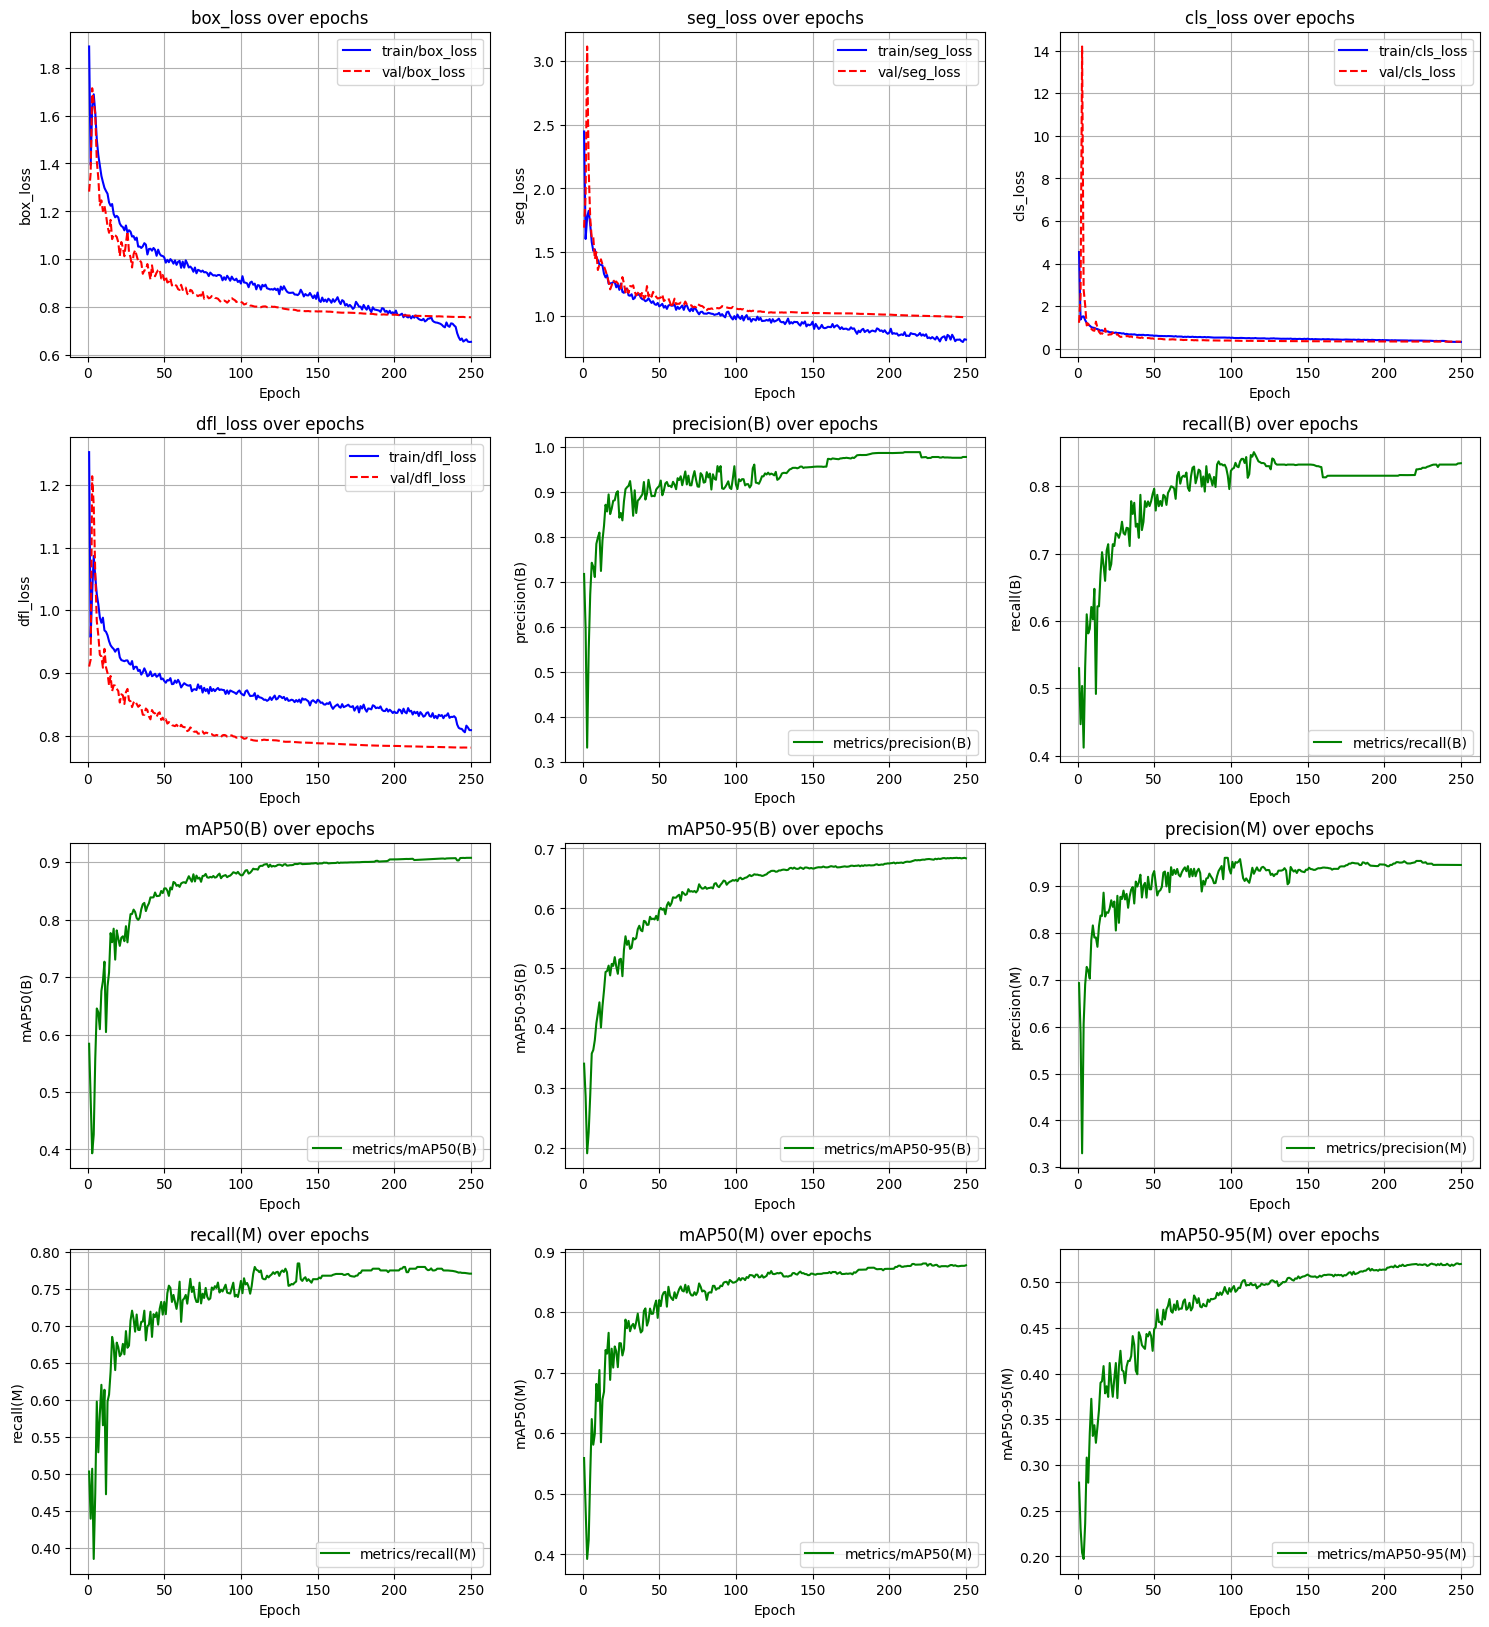

In [23]:
import math

df = df.drop(columns=['lr/pg1', 'lr/pg2'])

train_metrics = [col for col in df.columns if col.startswith('train/')]
val_metrics = [col.replace('train/', 'val/') for col in train_metrics if col.replace('train/', 'val/') in df.columns]
metric_metrics = [col for col in df.columns if col.startswith('metrics/')]

n_cols = 3
n_rows = math.ceil(len(train_metrics) / n_cols) + math.ceil(len(metric_metrics) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, train_metric in enumerate(train_metrics):
    val_metric = train_metric.replace('train/', 'val/')
    
    axes[i].plot(df['epoch'], df[train_metric], linestyle='-', label=f'{train_metric}', color='blue')
    axes[i].plot(df['epoch'], df[val_metric], linestyle='--', label=f'{val_metric}', color='red')
    
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel(train_metric.split('/')[-1])
    axes[i].set_title(f'{train_metric.split("/")[-1]} over epochs')
    axes[i].legend()
    axes[i].grid(True)

# Рисуем метрики metrics/
for j, metric in enumerate(metric_metrics, start=len(train_metrics)):
    axes[j].plot(df['epoch'], df[metric], linestyle='-', label=metric, color='green')
    
    axes[j].set_xlabel('Epoch')
    axes[j].set_ylabel(metric.split('/')[-1])
    axes[j].set_title(f'{metric.split("/")[-1]} over epochs')
    axes[j].legend()
    axes[j].grid(True)

# Удаление лишних подграфиков
for i in range(len(train_metrics) + len(metric_metrics), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig(f"grafics_{today}.png", dpi=300) 
plt.show()


0: 224x224 (no detections), 9.1ms
Speed: 0.5ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 1 tumor, 9.3ms
Speed: 0.8ms preprocess, 9.3ms inference, 18.8ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 9.9ms
Speed: 0.8ms preprocess, 9.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 10.8ms
Speed: 0.9ms preprocess, 10.8ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 224)


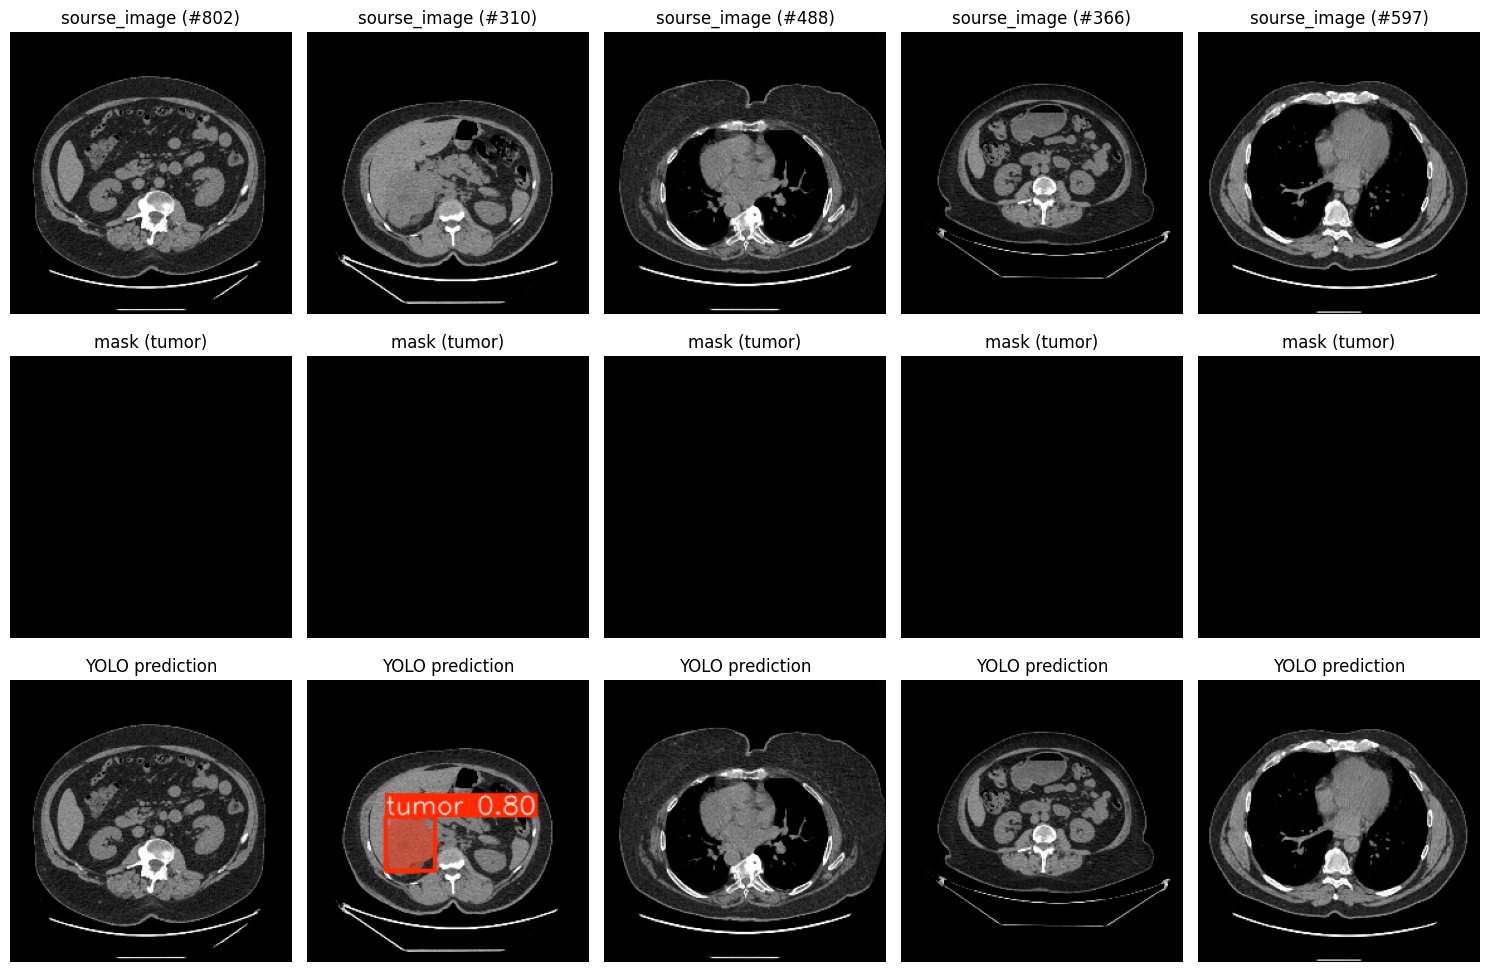

In [24]:
import random

# Выбираем 5 случайных индексов из images_saved
random_indices = random.sample(range(len(images_saved)), 5)

# Создаем фигуру для графиков (3 строки, 5 столбцов)
fig, axes = plt.subplots(3, 5, figsize=(15, 10))

for col, kadr in enumerate(random_indices):
    # Загружаем изображения
    img = images_saved[kadr]
    img_seg = masks_saved_images[kadr]

    # Преобразуем в BGR → RGB
    img_pred = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Получаем предсказание YOLO
    prediction = model.predict(img_pred)

    # Конвертируем результат YOLO в NumPy
    predicted_img = prediction[0].plot()

    # Заполняем текущий столбец из 3 изображений
    axes[0, col].imshow(img, cmap='gray', vmin=0, vmax=255)
    axes[0, col].set_title(f"sourse_image (#{kadr})")
    axes[0, col].axis('off')

    axes[1, col].imshow(img_seg, cmap='gray', vmin=0, vmax=255)
    axes[1, col].set_title("mask (tumor)")
    axes[1, col].axis('off')

    axes[2, col].imshow(predicted_img)
    axes[2, col].set_title("YOLO prediction")
    axes[2, col].axis('off')

plt.tight_layout()
plt.savefig(f"examples_{today}.png", dpi=300)
plt.show()

In [25]:
img = images_saved[63]
img_pred = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
prediction = model.predict(img_pred)
print(prediction[0].boxes)


0: 224x224 (no detections), 14.0ms
Speed: 0.8ms preprocess, 14.0ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 224)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([], device='cuda:0')
conf: tensor([], device='cuda:0')
data: tensor([], device='cuda:0', size=(0, 6))
id: None
is_track: False
orig_shape: (224, 224)
shape: torch.Size([0, 6])
xywh: tensor([], device='cuda:0', size=(0, 4))
xywhn: tensor([], device='cuda:0', size=(0, 4))
xyxy: tensor([], device='cuda:0', size=(0, 4))
xyxyn: tensor([], device='cuda:0', size=(0, 4))


# Проверка модели на видео (прогоню каждый кард через модель, выгружу npy и mp4)

In [26]:
model = os.path.join(project_dir, 'yolo_seg_small_040325.pt')
model = YOLO(model)

In [27]:
# цикл пикл
import cv2
import numpy as np
from pathlib import Path

def process_and_save_video_all(video_array: np.ndarray,
                               model,
                               output_original: str,
                               output_detection: str,
                               output_segmentation: str,
                               conf_threshold: float = 0.5,
                               mask_threshold: float = 0.5,
                               fps: int = 10,
                               detection_color: tuple = (0, 255, 0),
                               mask_color: tuple = (255, 255, 255)):
    """
    Обрабатывает видео и сохраняет три файла:
      1) оригинальное видео,
      2) видео с детекцией bbox,
      3) видео с бинарными масками сегментации.

    :param video_array: np.ndarray формы (N, H, W) или (N, H, W, 3)
    :param model: YOLOv11_seg-модель (Ultralytics), поддерживает task="segment"
    :param output_original: путь для сохранения оригинального видео (.mp4)
    :param output_detection: путь для видео с детекцией bbox
    :param output_segmentation: путь для видео с сегментацией (чёрно-белые кадры)
    :param conf_threshold: минимальный confidence для боксов
    :param mask_threshold: порог бинаризации вероятностных масок
    :param fps: кадры в секунду
    :param detection_color: цвет bbox (B, G, R)
    :param mask_color: цвет объекта в маске (по умолчанию белый)
    """
    N, H, W = video_array.shape[0], video_array.shape[1], video_array.shape[2]

    # Подготовка трёх VideoWriter’ов
    def make_writer(path):
        p = Path(path)
        p.parent.mkdir(parents=True, exist_ok=True)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        return cv2.VideoWriter(str(p), fourcc, fps, (W, H))
    
    writer_orig = make_writer(output_original)
    writer_det  = make_writer(output_detection)
    writer_seg  = make_writer(output_segmentation)

    for i in range(N):
        frame = video_array[i]
        # приводим к BGR uint8
        if frame.ndim == 2:
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        else:
            frame_bgr = frame.astype(np.uint8)

        # 1) сохраняем оригинал
        writer_orig.write(frame_bgr)

        # 2) предсказание (детекция + сегментация)
        results = model(frame_bgr, conf=conf_threshold, task="segment", verbose=False)[0]

        # --- видео с детекцией bbox ---
        det_frame = frame_bgr.copy()
        for box in results.boxes.data.cpu().numpy():
            x1, y1, x2, y2, conf, cls = box
            if conf < conf_threshold:
                continue
            pt1 = (int(x1), int(y1))
            pt2 = (int(x2), int(y2))
            cv2.rectangle(det_frame, pt1, pt2, detection_color, 2)
            label = f"{results.names[int(cls)]} {conf:.2f}"
            cv2.putText(det_frame, label, (pt1[0], pt1[1] - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, detection_color, 2)
        writer_det.write(det_frame)

        # --- видео с сегментацией (бинарные маски) ---
        mask_output = np.zeros((H, W), dtype=np.uint8)
        if results.masks is not None and results.masks.data.numel() > 0:
            masks = results.masks.data.cpu().numpy()  # shape: (M, H, W)
            for mask in masks:
                binary = (mask > mask_threshold).astype(np.uint8) * mask_color[0]  # маска белая
                mask_output = np.maximum(mask_output, binary)
        mask_bgr = cv2.cvtColor(mask_output, cv2.COLOR_GRAY2BGR)
        writer_seg.write(mask_bgr)

    # закрываем все
    writer_orig.release()
    writer_det.release()
    writer_seg.release()

    print("Сохранены:")
    print(f"   • Оригинал:   {output_original}")
    print(f"   • Детекция:   {output_detection}")
    print(f"   • Сегментации:{output_segmentation}")

In [28]:
# Пример вызова:
num_video = 4

output_path=f'/kaggle/working/final_videos/'

process_and_save_video_all(
    video_array=videos_saved[num_video],
    model=model,
    output_original = output_path + f"video{num_video}.mp4",
    output_detection = output_path + f"video{num_video}_det.mp4",
    output_segmentation = output_path + f"video{num_video}_seg.mp4",
    conf_threshold=0.5,
    mask_threshold=0.5,
    fps=15
)

✅ Сохранены:
   • Оригинал:   /kaggle/working/final_videos/video4.mp4
   • Детекция:   /kaggle/working/final_videos/video4_det.mp4
   • Сегментации:/kaggle/working/final_videos/video4_seg.mp4
